# 2.2 Алгоритмы машинного обучения

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

path = 'data/'

In [94]:
movie_path = os.path.join(path, 'movies.xls')

In [95]:
movies_df = pd.read_csv(movie_path, sep=';')
movies_df

,Movie,Budget,Box office
0,Властелин колец: Две крепости,94,937
1,Гарри Поттер и Дары Смерти. Часть 2,125,1342
2,Форсаж 7,190,1516
3,Мир юрского периода,150,1672
4,Звёздные войны: Пробуждение силы,200,2068
5,Аватар,246,2834


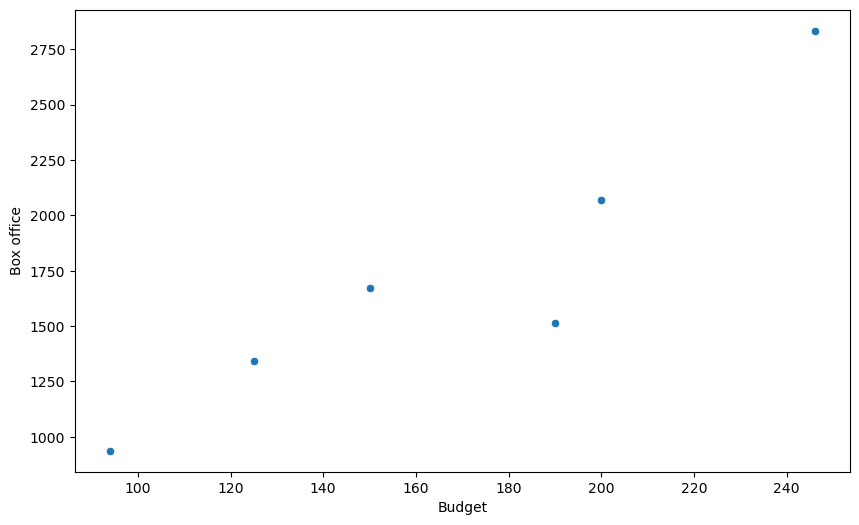

In [96]:
# Зависимость Кассового сбора от Бюджета

# fig = plt.figure(figsize=[10, 6])

plt.rcParams['figure.figsize']=(10, 6)

sns.scatterplot(x='Budget', y='Box office', data=movies_df)
plt.show();

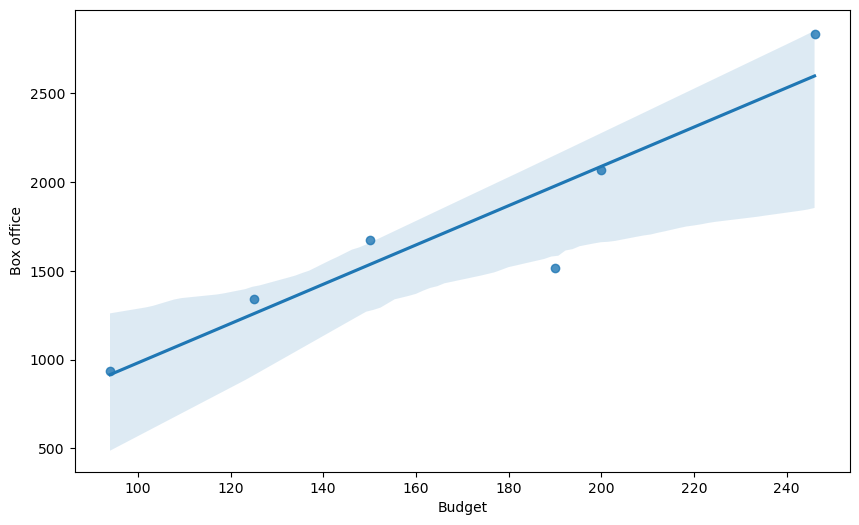

In [97]:
# Метод наименьших квадратов (минимизация функции потерь, т.е. среднеквадратичной ошибки) для построения прямой линейной регрессии
# Вместо нахождения среднеквадратичной ошибки возможно использовать среднеабсолютною ошибку (модуль)

sns.regplot(x='Budget', y='Box office', data=movies_df)
plt.show();

In [98]:
# Валидация - проверка качества модели
# Если данных мало, то используется кроссвалидация

# Если время обучения модели позволяет использовать кросс валидацию, то рекомендуется исползовать кроссвалидацию

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = movies_df['Budget']
y = movies_df['Box office']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=4, random_state=42)
display(X_test, y_test)

0     94
1    125
Name: Budget, dtype: int64

0     937
1    1342
Name: Box office, dtype: int64

In [100]:
logreg = LinearRegression()
logreg

LinearRegression()

In [101]:
res = logreg.fit(X_train.values.reshape(-1, 1), y_train.values)

In [102]:
y_pred = res.predict(X_test.values.reshape(-1, 1))

In [103]:
from sklearn.metrics import mean_absolute_error

print(mean_absolute_error(y_test, y_pred))

233.9815727448041


# Прогнозирование стоимости бриллиантов

In [104]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn import preprocessing
import lightgbm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [105]:
df = pd.read_csv(os.path.join(path, 'diamonds_moded.xls'), sep=';')
df.shape

(53940, 10)

In [106]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,NaN,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## Подготовка данных

In [107]:
# Проверка адекватности колонок (нельзя использовать данные, которые не будут доступны в продакшене)
# Обработка пропусков в данных (модели обычно не принимают пропуски в данных)
# Перевести категориальные значения в численные (модели обычно не принимают категориальные данные)

In [108]:
df.isna().sum()

carat       0
cut         0
color      10
clarity     0
depth       0
table       0
price       0
x           0
y           0
z           0
dtype: int64

In [109]:
# Замена пропусков в color модой

color_fillval  = df['color'].mode()[0]

df.loc[df['color'].isna(), 'color'] = df['color'].fillna(color_fillval)
df.isna().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [110]:
display(df.head())
df.dtypes

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,G,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [111]:
# Замена категориальных колонок

cat_columns = [cname for cname in df.columns if df[cname].dtype == 'object']
print(cat_columns)

# Альтернатива OneHot
encoder = preprocessing.LabelEncoder()

for col in cat_columns:
    df[col] = encoder.fit_transform(df[col])

display(df.head())
df.dtypes

['cut', 'color', 'clarity']


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,1,3,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,3,2,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,335,4.34,4.35,2.75


carat      float64
cut          int32
color        int32
clarity      int32
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [112]:
# Делим датасет на Х и у, выделяем часть для обучения и валидации

X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Обучение BaseLine моделей

In [113]:
# LinearRegression()

# cv - части кроссвалидации (5)
# scoring - метрика (средняя абсолюная ошибка)

lr = LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

print("Linear Reagression cross validation MAE:", - np.mean(scores))

Linear Reagression cross validation MAE: 864.6457278999576


In [114]:
# DecisionTreeRegressor()

dt = DecisionTreeRegressor()
scores = cross_val_score(dt, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

print('Decision Tree cross validation MAE:', - np.mean(scores))

Decision Tree cross validation MAE: 370.37646555914955


In [115]:
# RandomForestRegressor()

rf = RandomForestRegressor(random_state=0)
# scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

# print('Random Forest cross validation MAE:', - np.mean(scores))

# 1m 3.8s
# Random Forest cross validation MAE: 277.43261557752004

In [116]:
# LightGBM

lgb = lightgbm.LGBMRegressor(random_state=0)
scores = cross_val_score(lgb, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

print('Cross validation MAE:', - np.mean(scores))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1269
[LightGBM] [Info] Number of data points in the train set: 34521, number of used features: 9
[LightGBM] [Info] Start training from score 3950.741664
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1260
[LightGBM] [Info] Number of data points in the train set: 34521, number of used features: 9
[LightGBM] [Info] Start training from score 3919.524434
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not e

## Подбор параметров и окончательный выбор модели

In [117]:
def cv_params(model, param_grid):
    scoring = 'neg_mean_absolute_error'

    opt_params = GridSearchCV(
        estimator=model,           # Модель
        param_grid=param_grid,     # Параметры
        scoring=scoring,           # Стратегия валидации
        cv=5,                      # Количество слоев кросс валидации
        n_jobs=-1)                 # Количество потоков для обучения, -1 = все

    opt_params.fit(X_train, y_train)
    params = opt_params.best_params_
    bast_score = opt_params.best_score_

    print(f'Best score: {round(-bast_score, 2)}')
    print(f'Best parameters: {params}\n')

    return params

In [118]:
# LightGBM
lgb_param_grid = {
                'max_depth': [9, -1],              # Максимальная глубина дерева
                'num_leaves': [39, 40, 41],        # Максимальное кол-во листьем на дереве
                'n_estimators': [279, 280, 281]    # Количество деревьев
                }

lgb_clean = lightgbm.LGBMRegressor(random_state=1)
lgb_params = cv_params(lgb_clean, lgb_param_grid)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 43152, number of used features: 9
[LightGBM] [Info] Start training from score 3931.979236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [119]:
# Random Forest
rf_param_grid = {
               'max_depth': [20, 25],              # Максимальная глубина дерева
               'n_estimators': [500, 800]          # Количество деревьев
                }

rf_clean = RandomForestRegressor(random_state=1)
# rf_params = cv_params(rf_clean, rf_param_grid)

# 8m 5.2s
# Best score: 276.0
# Best parameters: {'max_depth': 20, 'n_estimators': 800}

In [120]:
# Итоговая модель LightGBM
# Обучаем на лучших параметрах, смотрим MAPE

In [121]:
lgb = lightgbm.LGBMRegressor(**lgb_params)
lgb.fit(X_train, y_train)

preds = lgb.predict(X_test)

print(f'MAPE: {round(mean_absolute_percentage_error(y_test, preds) * 100, 2)}%')
print(f'MAE: {round(mean_absolute_error(y_test, preds), 2)}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 43152, number of used features: 9
[LightGBM] [Info] Start training from score 3931.979236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [122]:
results = pd.DataFrame({'Model': np.round(preds), 'Actual': y_test})
results = results.reset_index().drop('index', axis=1)

print(results.head(15))
print(lgb.fit(X, y))

      Model  Actual
0     524.0     564
1    5727.0    5914
2    2574.0    2562
3     519.0     537
4    6017.0    5964
5    1264.0     984
6    5111.0    5247
7     584.0     611
8   10871.0    9645
9    1040.0    1162
10    687.0     710
11   1647.0    1574
12   1885.0    1662
13    853.0     787
14    487.0     487
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293
[LightGBM] [Info] Number of data points in the train set: 53940, number of used features: 9
[LightGBM] [Info] Start training from score 3932.799722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spli

In [123]:
# Обучение на всех данных

lgb.fit(X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1293


[LightGBM] [Info] Number of data points in the train set: 53940, number of used features: 9
[LightGBM] [Info] Start training from score 3932.799722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

LGBMRegressor(max_depth=9, n_estimators=281, num_leaves=41)

# 2.4 Основы визуализации данных

Библиотека на Python для построения самых распространенных видов графиков: https://matplotlib.org/ <br>
Более продвинутая библиотека визуализации на Python для построения графиков: https://seaborn.pydata.org/index.html <br>
Библиотека Plotly для построения интерактивных дашбордов: https://plotly.com/dash/
<br> <br>
Способы визуализация гео-данных: https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/ <br>
Способы визуализация для интерпретации моделей машинного обучения: https://github.com/slundberg/shap

# 3.4 Библиотеки Python для визуализаций данных: Matplotlib и Seaborn

https://matplotlib.org/ - Официальная документация по Matplotlib

https://seaborn.pydata.org/ - Официальная документация по Seaborn

https://pythonworld.ru/novosti-mira-python/scientific-graphics-in-python.html - Серия статей по визуализации на Matplotlib

https://www.w3schools.com/python/matplotlib_pyplot.asp - Поэтапно объясняют работу Matplotlib

https://habr.com/ru/company/otus/blog/540526/ - Красивые графики в Seaborn

https://mipt-stats.gitlab.io/courses/python/09_seaborn.html - Классный материал по Seaborn

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [125]:
data = pd.read_csv('data/final_data.csv')
data.shape

(11330, 19)

In [126]:
data.head()

,Unnamed: 0,address,info,z_address,bathrooms,bedrooms,finishedsqft,lastsolddate,lastsoldprice,latitude,longitude,neighborhood,totalrooms,usecode,yearbuilt,zestimate,zindexvalue,zipcode,zpid
0,2,Address: 1160 Mission Street #2007,San FranciscoSales price: 1300000Sales date: ...,1160 Mission St UNIT 2007,2.0,2.0,1043.0,02/17/2016,1300000.0,37.778705,-122.412635,South of Market,4.0,Condominium,2007.0,1167508.0,"975,700",94103.0,83152781.0
1,5,Address: 260 King Street #475,San FranciscoSales price: 750000Sales date: 0...,260 King St UNIT 475,1.0,1.0,903.0,02/17/2016,750000.0,37.777641,-122.393417,South of Market,3.0,Condominium,2004.0,823719.0,"975,700",94107.0,69819817.0
2,7,Address: 560 Missouri Street #B,San FranciscoSales price: 1495000Sales date: ...,560 Missouri St # B,4.0,3.0,1425.0,02/17/2016,1495000.0,37.759198,-122.396516,Potrero Hill,6.0,Condominium,2003.0,1708594.0,"1,277,600",94107.0,64972847.0
3,9,Address: 350 Missouri Street,San FranciscoSales price: 2700000Sales date: ...,350 Missouri St,3.0,3.0,2231.0,02/17/2016,2700000.0,37.761886,-122.396769,Potrero Hill,10.0,SingleFamily,1927.0,2411236.0,"1,277,600",94107.0,15149489.0
4,11,Address: 3658 Folsom Street,San FranciscoSales price: 1530000Sales date: ...,3658 Folsom St,3.0,3.0,1300.0,02/17/2016,1530000.0,37.740795,-122.413453,Bernal Heights,4.0,SingleFamily,1900.0,1918539.0,"1,248,000",94110.0,15161978.0


In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11330 entries, 0 to 11329
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     11330 non-null  int64  
 1   address        11330 non-null  object 
 2   info           11330 non-null  object 
 3   z_address      11330 non-null  object 
 4   bathrooms      11330 non-null  float64
 5   bedrooms       11330 non-null  float64
 6   finishedsqft   11330 non-null  float64
 7   lastsolddate   11330 non-null  object 
 8   lastsoldprice  11330 non-null  float64
 9   latitude       11330 non-null  float64
 10  longitude      11330 non-null  float64
 11  neighborhood   11330 non-null  object 
 12  totalrooms     11330 non-null  float64
 13  usecode        11330 non-null  object 
 14  yearbuilt      11330 non-null  float64
 15  zestimate      11330 non-null  float64
 16  zindexvalue    11330 non-null  object 
 17  zipcode        11330 non-null  float64
 18  zpid  

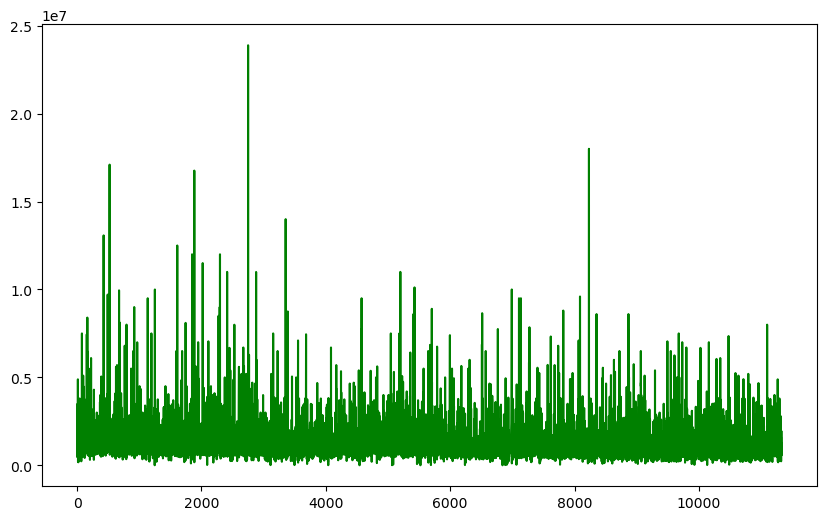

In [128]:
plt.figure(figsize=[10, 6])
data['lastsoldprice'].plot(color='green')
plt.show();

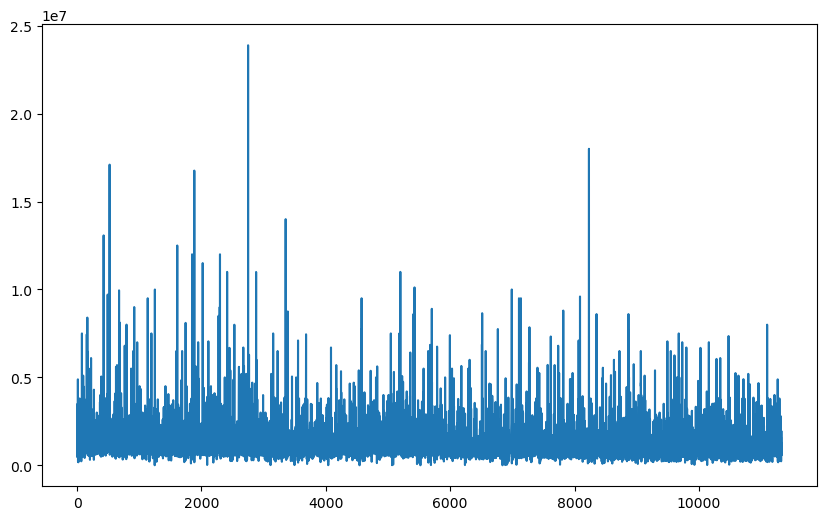

In [129]:
plt.figure(figsize=[10, 6])
plt.plot(data['lastsoldprice'])
plt.show();

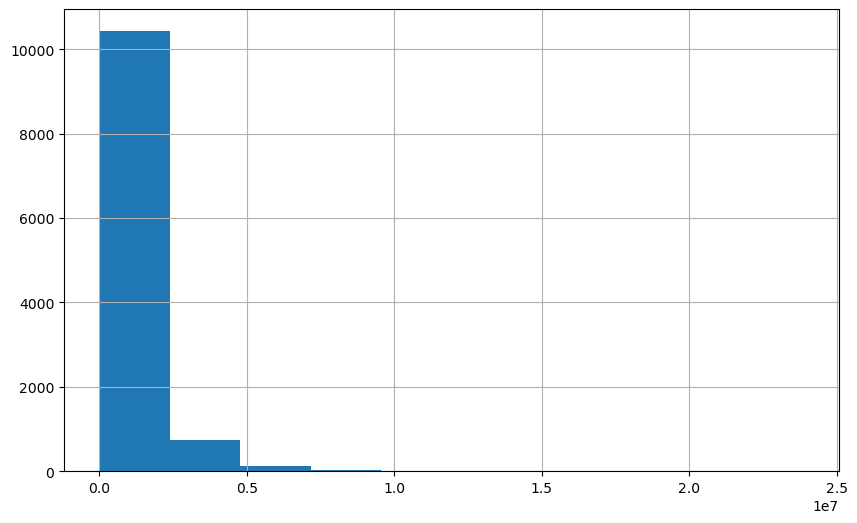

In [130]:
plt.figure(figsize=[10, 6])
data['lastsoldprice'].hist()
plt.show();

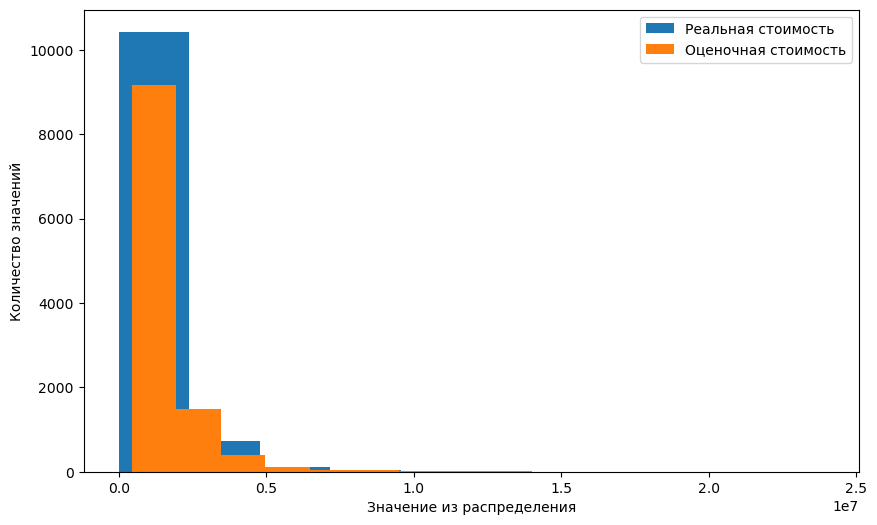

In [131]:
plt.figure(figsize=[10, 6])

plt.hist(data['lastsoldprice'])
plt.hist(data['zestimate'])

plt.legend(['Реальная стоимость', 'Оценочная стоимость'])

plt.xlabel('Значение из распределения')
plt.ylabel('Количество значений')

plt.show();

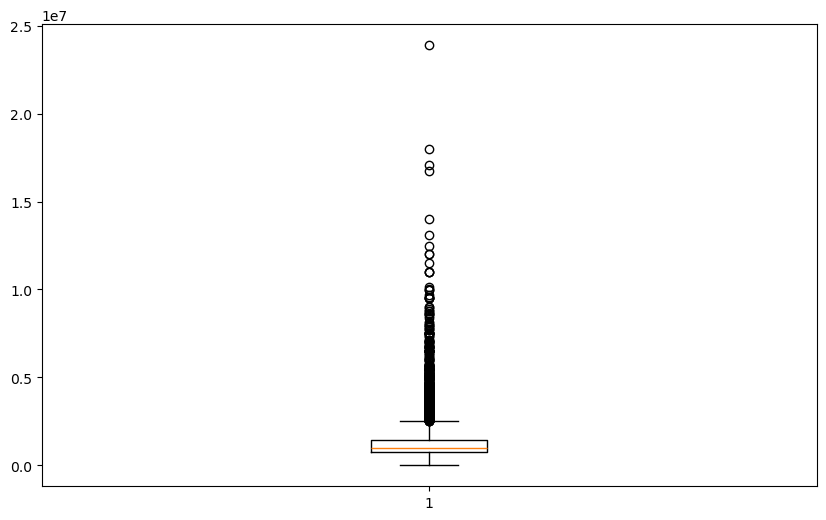

In [132]:
plt.figure(figsize=[10, 6])

plt.boxplot(data['lastsoldprice'])

plt.show();

In [133]:
data.columns

Index(['Unnamed: 0', 'address', 'info', 'z_address', 'bathrooms', 'bedrooms',
       'finishedsqft', 'lastsolddate', 'lastsoldprice', 'latitude',
       'longitude', 'neighborhood', 'totalrooms', 'usecode', 'yearbuilt',
       'zestimate', 'zindexvalue', 'zipcode', 'zpid'],
      dtype='object')

In [134]:
group = data.groupby('usecode')['lastsoldprice'].mean().round(2)
group_est = data.groupby('usecode')['zestimate'].mean().round(2)
group

usecode
Apartment           1341666.67
Condominium         1083701.40
Cooperative          906666.67
Duplex              1416006.85
Miscellaneous       1579941.18
Mobile              1697000.00
MultiFamily2To4     1322210.88
MultiFamily5Plus     678000.00
SingleFamily        1408017.87
Townhouse            878167.20
Name: lastsoldprice, dtype: float64

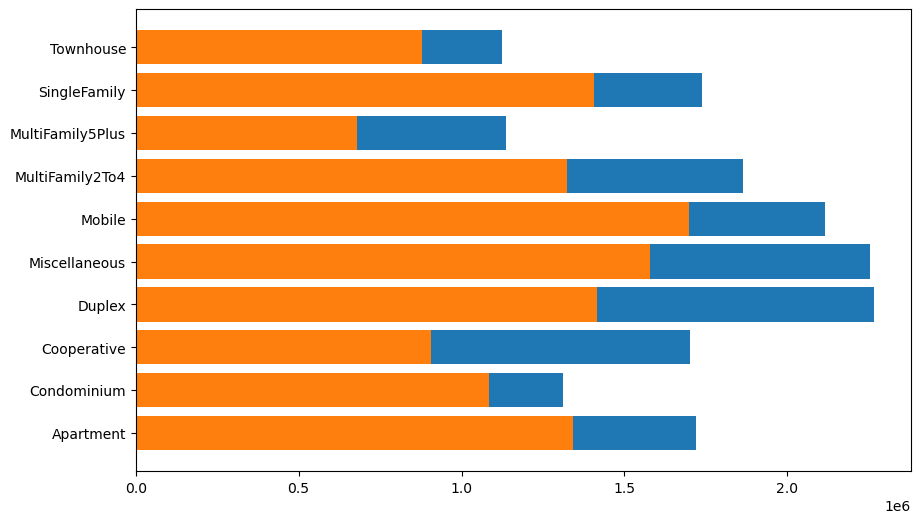

In [135]:
plt.figure(figsize=[10, 6])

plt.barh(group_est.index, group_est.values)
plt.barh(group.index, group.values)

plt.show();

In [136]:
# plt.figure(figsize=[10, 6])

# sns.pairplot(data)

# plt.show();

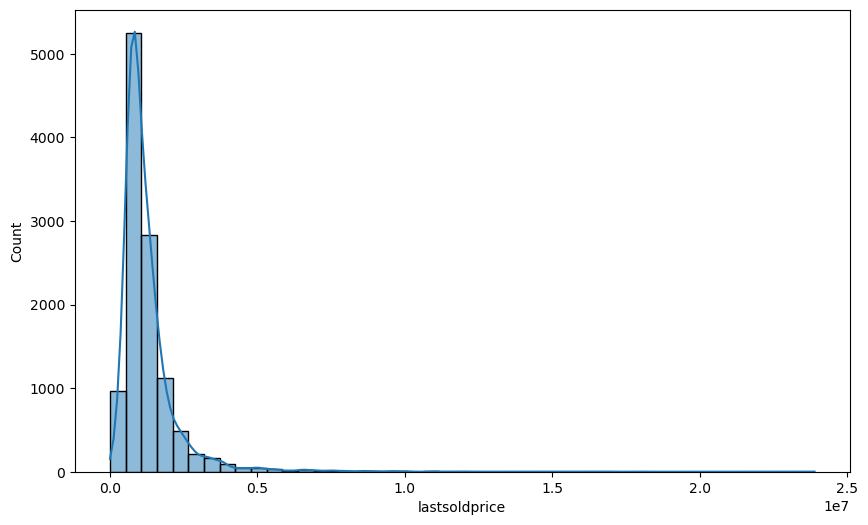

In [137]:
plt.figure(figsize=[10, 6])

sns.histplot(data['lastsoldprice'], kde=True, bins=45)

plt.show();

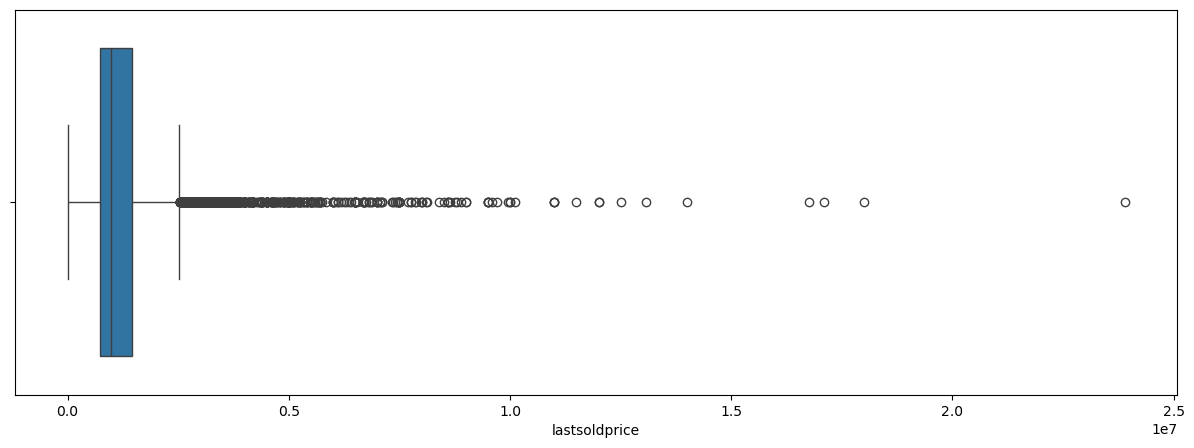

In [138]:
plt.figure(figsize=[15, 5])

sns.boxplot(data['lastsoldprice'], orient='h')

plt.show();

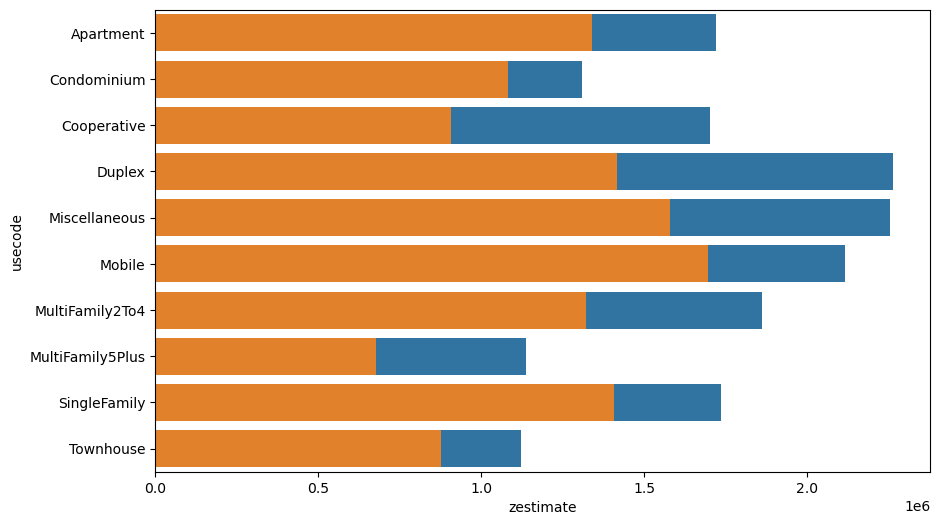

In [139]:
plt.figure(figsize=[10, 6])

sns.barplot(group_est, orient='h')
sns.barplot(group, orient='h')

plt.show();

# 3.5 Data processing and summarization

In [140]:
# Обработка данных нужна в случаях:

# Пропуски в данных (NaN)
# Разный масштаб переменных
# Коррелированные переменные
# Наличие категориальных переменных
# Выбросы
# Дисбаланс классов
# Ошибка разметки, дубликаты,\ шумы

In [141]:
# Перебалансировка - это когда мы делаем классы сбалансированными, 
# для этого заменяем большой класс подвыборкой по мощности равной малому классу – 
# это называется недосэмлированием (Undersampling the majority class) 
# или «увеличиваем в размерах малый класс» – это называется пересемплированием (Oversampling the minority class). 

# Простейшая стратегия недосэмплирования – взять случайную подвыборку, 
# простейшая стратегия пересэмплирования – продублировать объекты малого класса.

# Мажоритарный класс - класс, доля примеров которого оказывается слишком большой, преобладающей. 
# Если количество мажоритарных классов большое - их можно безболезненно сократить (undersampling), 
# если маленькое - увеличить (oversampling). 

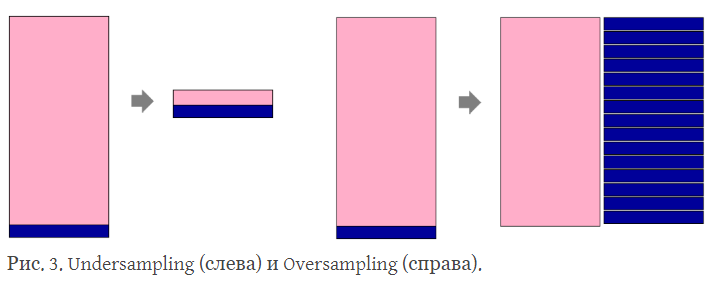

# 3.6 Применение алгоритмов машинного обучения

# Часть 1: ML workflow

В этой части занятия мы познакомимся с базовым процессом решения задачи машинного обучения. Мы пройдем путь от загрузки данных до обучения модели и тестирования.

Задача, которую мы будем решать: задача предсказания сердечно-сосудистых заболеваний у людей. Ссылка на датасет: https://disk.yandex.ru/d/8CNIk7GdkBop2A

## Загрузка данных

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [143]:
train_data = pd.read_csv(path + "ssz_data/train.csv")
train_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,58036,18387,2,175,75.0,110,70,1,1,0,0,1,1
1,88981,23328,2,155,66.0,140,90,1,1,1,1,0,0
2,74325,17602,2,168,73.0,120,80,2,1,0,0,1,0
3,16519,23432,2,183,95.0,140,90,1,1,0,0,0,1
4,28981,23162,1,156,62.0,150,80,1,1,0,0,1,1


In [144]:
test_data = pd.read_csv(path + "ssz_data/test.csv")
test_data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,36043,17646,2,165,65.0,120,80,1,1,0,0,0,1
1,44455,20418,1,161,77.0,120,70,1,1,0,0,1,1
2,61323,20347,1,165,88.0,120,80,2,2,0,0,1,1
3,27780,18086,2,170,91.0,120,80,3,3,0,0,1,1
4,54273,21791,1,158,67.0,130,80,1,1,0,0,1,1


Видим, что, как и должно быть, тестовые данные содержат все слолбцы, что есть в тренировочных данных, кроме столбца с целевой переменной — "cardio". Целевая переменная принимает значения 0 или 1. 0 значит, что у человека нет ССЗ, 1 — что есть.

Таким образом, наша задача — задача бинарной классификации.

Давайте посмотрим на информацию о признаках в данных:

In [145]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58000 entries, 0 to 57999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           58000 non-null  int64  
 1   age          58000 non-null  int64  
 2   gender       58000 non-null  int64  
 3   height       58000 non-null  int64  
 4   weight       58000 non-null  float64
 5   ap_hi        58000 non-null  int64  
 6   ap_lo        58000 non-null  int64  
 7   cholesterol  58000 non-null  int64  
 8   gluc         58000 non-null  int64  
 9   smoke        58000 non-null  int64  
 10  alco         58000 non-null  int64  
 11  active       58000 non-null  int64  
 12  cardio       58000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 5.8 MB


Видим, что в данных нет пропусков и что все данные представлены в числовом виде. На таких данных можно обучать модель машинного обучения. Конечно, в реальных задачах перед этапом обучения моделей есть еще этап предобработки данных — и этот этап занимает бóльшую часть времени дата саентиста. Но об это мы поговорим в следующей части нашего занятия. Пока давайте просто научимся обучать и тестировать модели машинного обучения.

Поделим тренировочные данные на признаки и целевую переменную. Это нужно, потому что на вход моделям машинного обучения признаки и целевая переменная подаются отдельно.

In [146]:
X_train = train_data.drop(columns=['cardio'])
y_train = train_data['cardio']

То же самое для текстовых данных:

In [147]:
X_test = test_data.drop(columns=['cardio'])
y_test = test_data['cardio']

## Обучение моделей

Обучим две модели машинного обучения: логистическую регрессию и случайный лес.

### Логистическая регрессия

Документация: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [148]:
# импортируем логрегрессию из библиотеки sklearn
from sklearn.linear_model import LogisticRegression

Заводим экземпляр класса нашей модели:

In [149]:
logreg = LogisticRegression()

Чтобы обучить модель, нужно вызвать у нее функцию fit (в переводе с английского — "обучиться", "подстроиться"). В fit нужно передать два аргумента: тренировочные данные и ответы к тренировочным данным. Именно потому что модели из sklearn для обучения принимают признаки и целевую переменную в разных аргументах, мы выше делили train_data на две переменные X_train и y_train.

In [150]:
logreg.fit(X_train, y_train)

c:\Users\kuche\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Все! Теперь в переменной logreg у нас лежит обученная модель, которая может давать предсказания на новые данные. Ничего больше для обучения модели делать не нужно: вся магия, о которой вы слышали на теоретических занятиях, происходит внутри библиотеки sklearn. Ничего руками обучать не нужно.

Давайте попросим у обученной логистической регрессии ответы на тестовые данные: для этого нужно вызвать функцию predict (с английского — "предскажи"), и передать ей тестовые данные (без ответов, разумеется! Ведь мы же хотим, чтобы логрегрессия предсказала нам эти ответы =)

In [151]:
y_predicted_logreg = logreg.predict(X_test)

In [152]:
y_predicted_logreg

array([0, 1, 1, ..., 0, 1, 1], dtype=int64)

Как видим, в переменной y_predicted_logreg теперь находятся ответы на каждцю строчку тестовых данных. Давайте выведем первые 10 ответов модели и первые 10 правильных ответов:

In [153]:
y_predicted_logreg[:10]

array([0, 1, 1, 0, 1, 1, 0, 0, 1, 0], dtype=int64)

In [154]:
np.array(y_test)[:10]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int64)

Видим, что в некоторых случаях наша модель ошиблась, а в некоторых дала правильный ответ. Прежде чем выяснять, что же с этим делать, давайте обучим на наших данных еще одну модель машинного обучения:

### Случайный лес

Документация: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [155]:
# импортируем случайный лес из библиотеки sklearn
from sklearn.ensemble import RandomForestClassifier

Случайный лес — модель, совершенно идейно отличающаяся от логистической регрессии. Логрегрессия строит разделяющую плоскость, а случайный лес — много решающих деревьев с решающими правилами. Но при этом процесс обучения этих двух моделей (и многих других моделей из sklearn) в коде — совершенно одинаков. Для случайного леса, как и для логрегрессии, нужно:
- завести экземпляр класса
- вызвать функцию fit, передав ей в качестве аргументов тренировочные данные и ответы на них
- для получения предсказаний вызвать функцию predict, передав ей в качестве аргумента данные, на которые хочется получить предсказания.

То, что в sklearn процесс обучения и получения предсказаний для всех моделей машинного обучения одинаков — это очень удобно. Тот же самый процесс будет и для других моделей: SVM, KNN, многих других.

Итак, заведем экземпляр класса Random Forest:

Заметим, что у RandomForest есть много разных параметров, которые можно задать: количество деревьев в лесу, максимальная глубина каждого дерева и т.д. (полный список параметров и их описания читайте в документации sklearn, ссылка была выше).

Не обязательно задавать все параметры: у них есть значения по умолчанию, которые применятся, если вы их не зададите. Давайте ради интереса зададим два параметра: количество деревьев, которые будет обучать (n_estimators) — пусть их будет 20; и максимальную глубину каждого дерева (max_depth) — пусть она будет 10.

In [156]:
rf = RandomForestClassifier(n_estimators=20, max_depth=10)

Обучим:

In [157]:
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=20)

Получим предсказания на тесте:

In [158]:
y_predicted_rf = rf.predict(X_test)

In [159]:
y_predicted_rf[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 1, 0], dtype=int64)

In [160]:
np.array(y_test)[:10]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int64)

Опять видим, что наш случайный лес где-то выдает правильные ответы, а где-то ошибается.

Но как понять, какая из моделей — logreg или random forest — лучше? Для этого существуют **метрики качества** — функции, которые оценивают, насколько хорошие модель выдала предсказания. Давайте посчитаем метрики качества для наших двух моделей:

## Метрики качества

Чтобы оценить, насколько одна модель работает лучше, чем другая, посчитаем для ответов моделей на тестовой выборки метрики качества.

Начнем с довольно простой метрики: **Accuracy**

#### Accuracy

Accuracy — это доля правильно угаданных ответов. Документация: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

In [161]:
from sklearn.metrics import accuracy_score

In [162]:
accuracy_score(y_predicted_logreg, y_test)

0.6925833333333333

In [163]:
accuracy_score(y_predicted_rf, y_test)

0.7315

Видим, что с точки зрения Accuracy модель случайного леса работает лучше, чем модель линейной регрессии.

#### F1

F1 — другая метрика качества бинарной классификации, используемая в машинном обучении. Документация: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [164]:
from sklearn.metrics import f1_score

In [165]:
f1_score(y_predicted_logreg, y_test)

0.6844581301856129

In [166]:
f1_score(y_predicted_rf, y_test)

0.7177150867355879

Видим, что с точки зрения F1 модель случайного леса также выдала лучшие предсказания, чем логрегрессия.

В машинном обучении существует много разных метрик для задач классификации и регрессии. Кроме Accuracy и F1 есть еще, например, logloss, ROC AUC, Precision, Recall, ...

То, какую метрику лучше использовать для оценки работы того или иного алгоритма машинного обучения, зависит от постановки задачи и от данных.

На этом часть с введением в практическое обучение моделей закончено. Мы прошли путь от загрузки данных до обучения моделей машинного обучения на этих данных и получения их предсказания. Наши данные были "чистые", поэтому все было так просто. Обычно с данными приходится повозиться прежде чем на них можно будет обучать модели. Об этом поговорим во второй части урока:

# Часть 2: предобработка данных

В этой части мы будем работать с датасетом цен на дома в Мельбурне: https://www.kaggle.com/dansbecker/melbourne-housing-snapshot

## Загрузка данных

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

In [168]:
data = pd.read_csv(path+'/melb_data.csv')
data.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [169]:
answer = data['Price']
data = data.drop(columns=['Price'])

##  Деление выборки на train и test

В этом датасете заранее выборка не поделена на train и test. Нужно сделать это самим.

Никогда нельзя осуществлять предобработку данных на всем датасете до деления его на трейн и тест. Это нужно, чтобы избежать любого, даже косвенного использования информации из трейна в тестовом датасете.

In [170]:
from sklearn.model_selection import train_test_split

In [171]:
X_train, X_test, y_train, y_test = train_test_split(data, answer, test_size=0.2) # test_size — какая доля данных пойдет в тестовую выборку

Зачем вообще нужен train_test_split: почему нельзя просто разбить выборку на X_train и X_test, взяв 80% первых строк из data в X_train, а остальные оставить на X_test?

Ответ такой: train_test_split делит выборку так, чтобы по каждому признаку и целевой переменной распределения тренировочной части и тестовой части были одинаковы. Чтобы обучающая выборка была "такая же", как тестовая: содержала ту же долю мужчин/женщин и т.п.

Давайте убедимся, что train_test_split делит выборку на train и test так, чтобы распределения были одинаковы: построим гистограммы признаков.

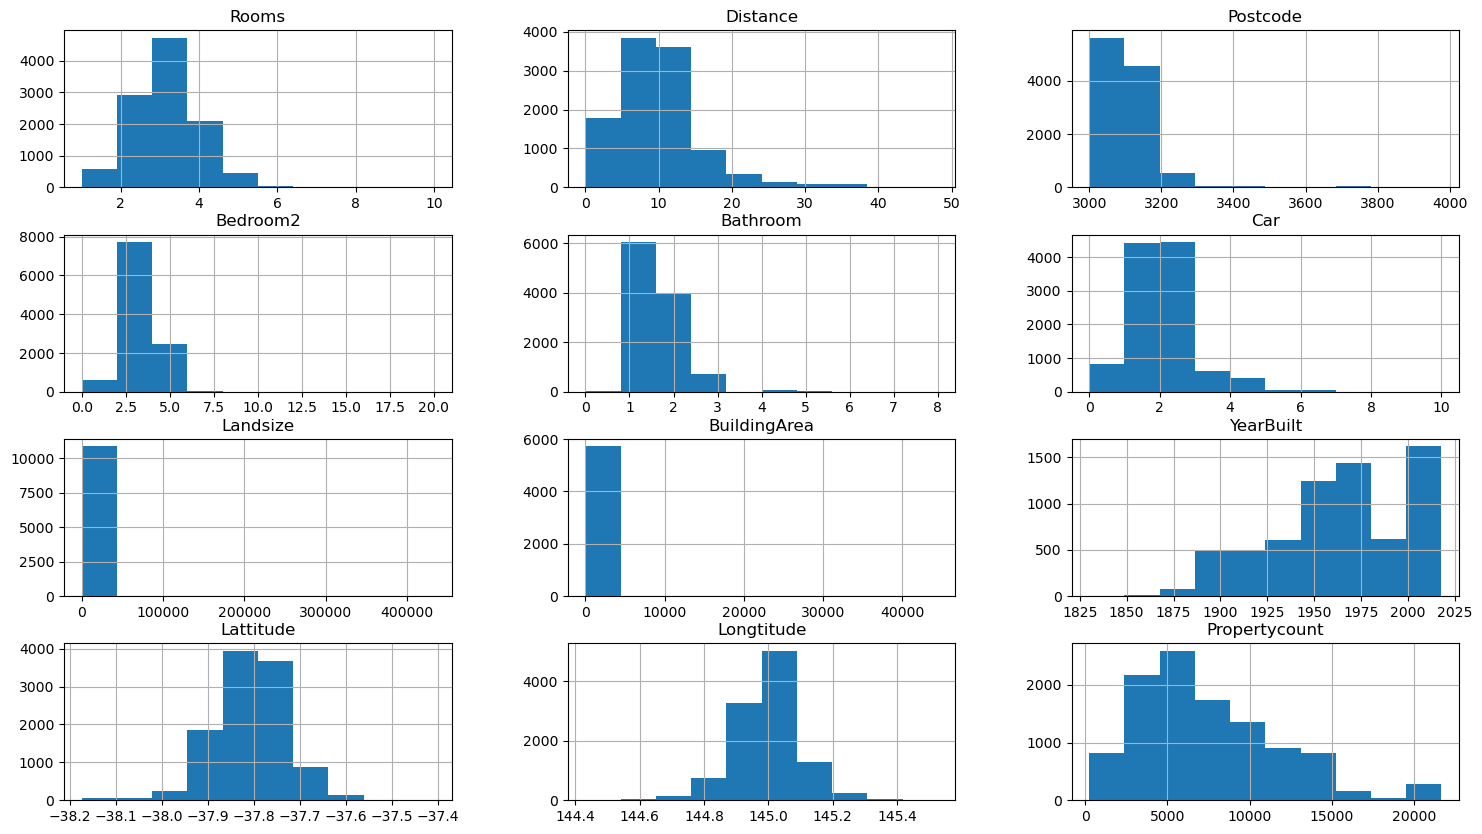

In [172]:
X_train.hist(figsize=(18, 10))
plt.show();

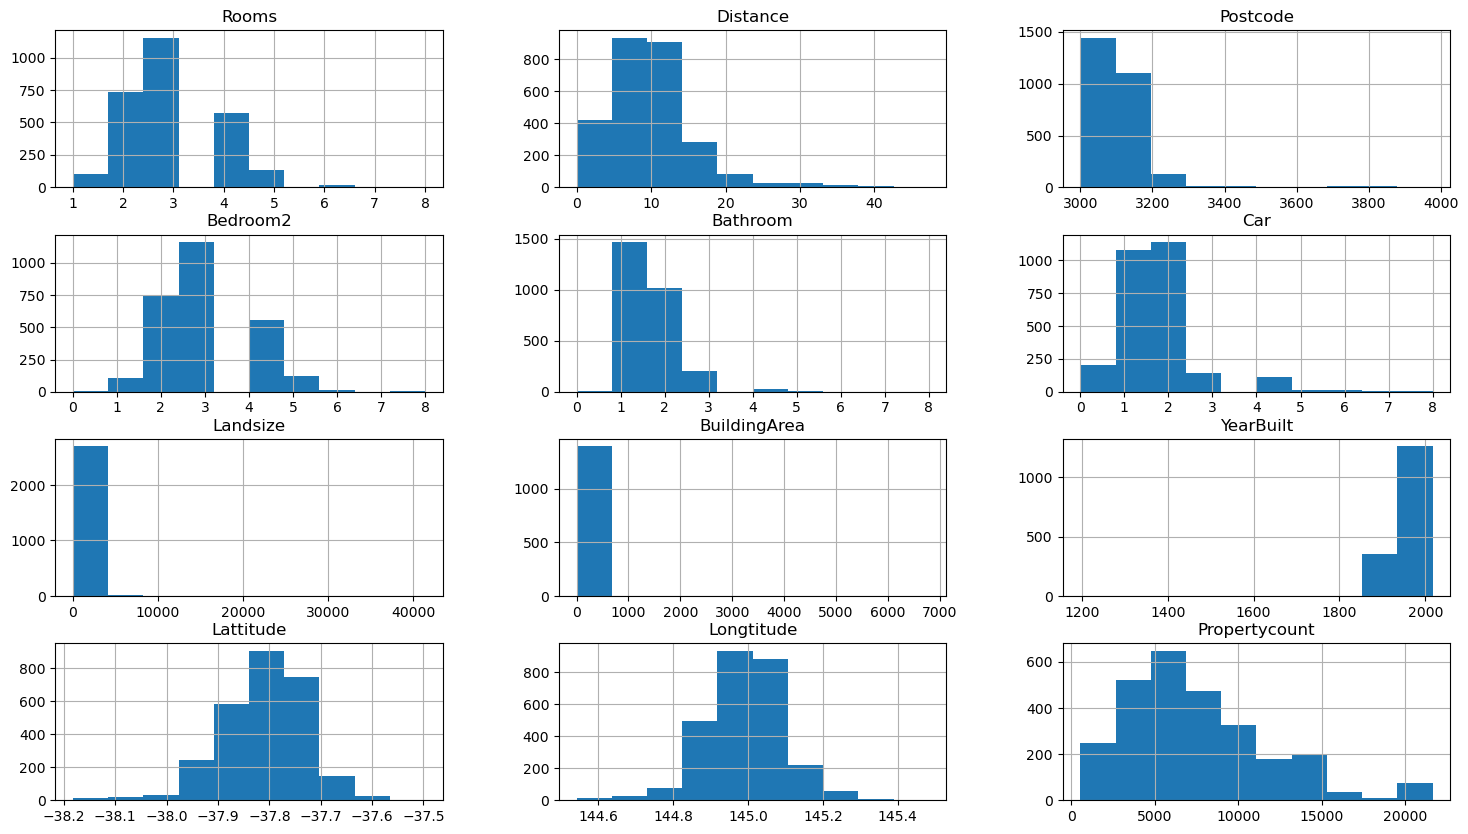

In [173]:
X_test.hist(figsize=(18, 10))
plt.show();

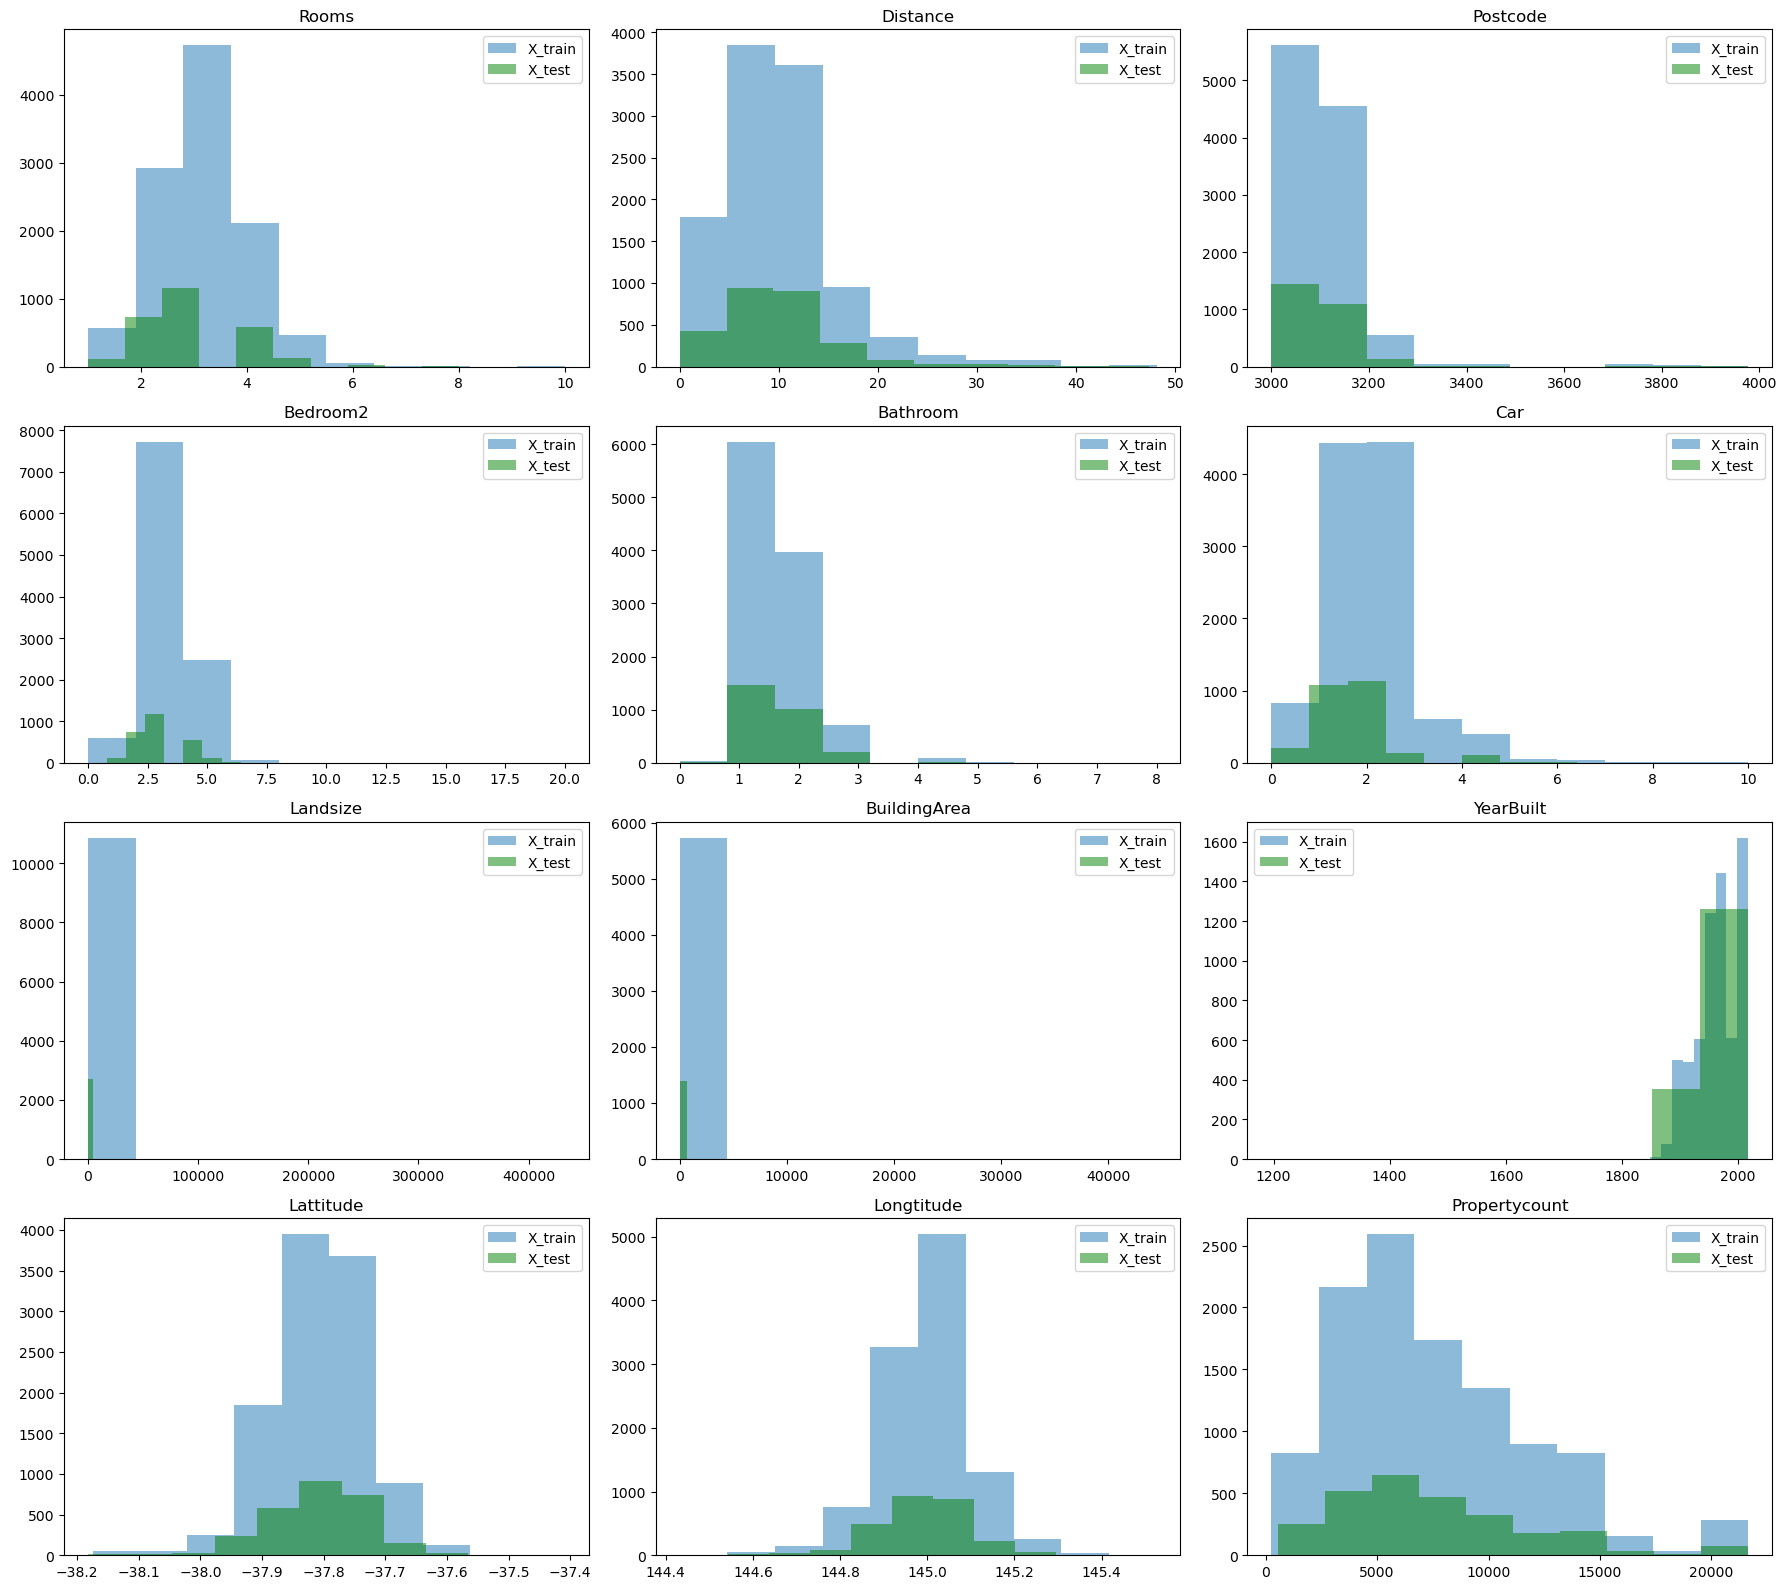

In [174]:
# Для сравнения распределений числовых признаков лучше использовать такой код: совмещает признаки трейна и теста на одном графике.

fig, axes = plt.subplots(4, 3, figsize=(18, 16))

for idx, col_name in enumerate(data.select_dtypes(include=[np.number])):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    
    ax.hist(X_train[col_name], alpha=0.5, label='X_train')
    ax.hist(X_test[col_name], alpha=0.5, color='g', label='X_test')
    
    ax.set_title(col_name)
    ax.legend()

plt.tight_layout()
plt.show()

Далее предобрабатывать мы будем только тренировочные данные (X_train). После того, как предобработаем X_train и обучим модели, предобработаем и X_test.

Нельзя исследовать предобработку данных сразу на X_train и X_test, во избежание использования любой, даже косвенной информации из X_test во время решения, как предобработать X_train.

## Предобработка признаков:

### Работа с пропусками

Прежде чем обучать сеть и обрабатывать признаки, нужно заполнить пропуски в столбцах. Никакой (почти) алгоритм машинного обучения не умеет работать с данными с пропусками.

Посмотрим, в каких столбцах есть пропуски:

In [175]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 12519 to 13333
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         10864 non-null  object 
 1   Address        10864 non-null  object 
 2   Rooms          10864 non-null  int64  
 3   Type           10864 non-null  object 
 4   Method         10864 non-null  object 
 5   SellerG        10864 non-null  object 
 6   Date           10864 non-null  object 
 7   Distance       10864 non-null  float64
 8   Postcode       10864 non-null  float64
 9   Bedroom2       10864 non-null  float64
 10  Bathroom       10864 non-null  float64
 11  Car            10815 non-null  float64
 12  Landsize       10864 non-null  float64
 13  BuildingArea   5728 non-null   float64
 14  YearBuilt      6589 non-null   float64
 15  CouncilArea    9797 non-null   object 
 16  Lattitude      10864 non-null  float64
 17  Longtitude     10864 non-null  float64
 18  Regionn

Видим, что пропуски есть в столбцах Car, BuildingArea, YearBuilt, CouncilArea.

#### Заполнение константным значением

Есть разные стратегии заполнения пропусков в данных. Самая простая: заполнить все пропуски в столбце одним и тем же значением.

Это значение может быть разным в зависимости от типа столбца и от ваших знаний о том, что за информация содержится в столбце. Иногда логично заполнить пропуски в числовом столбце нулями, а иногда — средним значением по столбцу.

Если никаких особых идей по заполнению пропусков нет, то у числовых переменных пропуски чаще всего заполняются медианным значением по столбцу, а у категориальных переменных — самым часто встречающимся значением по столбцу.

Для числовых признаков берется медиана (median), а не среднее (mean), потому что медиана меньше подвержена выбросам. Подумайте, какой средний и медианный возраст получится по столбцу "возраст" в данных, если у одного из людей в датасете в поле "возраст" стоит число 100000? Какое значение — mean или median — ближе отражает реальный "средний" возраст людей в датасете?

Для заполнения пропусков в столбцах одним значением используется метод библиотеки pandas filna() (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [176]:
# Car, BuildingArea и YearBuilt — числовые признаки, поэтому заполняем пропуски медианами по столбцам
X_train['Car'] = X_train['Car'].fillna(X_train['Car'].median())
X_train['BuildingArea'] = X_train['BuildingArea'].fillna(X_train['BuildingArea'].median())
X_train['YearBuilt'] = X_train['YearBuilt'].fillna(X_train['YearBuilt'].median())

# CouncilArea — категориальный признак, поэтому заполним наны самым часто встречающимся значением по столбцу

most_frequent_value = X_train['CouncilArea'].value_counts().index[0] # получаем самое часто встречающееся значение признака CouncilArea
# заполняем наны в столбце CouncilArea полученным значением
X_train['CouncilArea'] = X_train['CouncilArea'].fillna(most_frequent_value)

#### KNNImputer

Второй вариант заполнения пропусков в данных — построение KNN моделей.

В чем суть: пусть у вас есть пропуски в колонке Car. Вы обучаете KNN на всем тренировочном датасете, но в качестве целевой переменной у вас Car. Обучаете, понятное дело, на тех строках, где в колонке Car значения не пропущены. Потом для всех строк, в которых в колонке Car значения пропущены, получаете предсказания KNN, и этими предсказаниями и заполняете пропуски.

По сути, вы заполняете пропуски в строках, основываясь на значениях в колонке Car в тех строках, которые сильнее всего похожи на вашу строку с пропущенным значением.

Есть хорошая новость: вам не нужно самому строить KNN, чтобы реализовать идею выше. В Sklearn есть KNNImputer, который сделает все за вас. При этом KNNImputer сразу заполнит пропуски во всех колонках ваших данных, в которых есть пропущенные значения, не нужно возиться с каждой колонкой отдельно.

**Важно!** KNNImputer работает только если в данных нет категориальных колонок. К сожалению, ни одна модель машинного обучения из Sklearn не умеет работать с данными, в которых есть категориальные признаки.

Если в ваших данных нет категориальных признаков, то заполнить пропуски с помощью KNNImputer можно так:

In [ ]:
# # заводим KNNImputer. Его же вы будете использовать для заполнения пропусков в тестовых данных
# imputer = KNNImputer(n_neighbors=5)
# # Обучаем KNNImputer на X_train
# imputer.fit(X_train)
# # Получаем новый new_X_train — данные как X_train, только без пропусков
# new_X_train = imputer.transform(X_train)

Проверим, что в данных не осталось пропусков:

In [178]:
X_train.isna().any()

Suburb           False
Address          False
Rooms            False
Type             False
Method           False
SellerG          False
Date             False
Distance         False
Postcode         False
Bedroom2         False
Bathroom         False
Car              False
Landsize         False
BuildingArea     False
YearBuilt        False
CouncilArea      False
Lattitude        False
Longtitude       False
Regionname       False
Propertycount    False
dtype: bool

Если везде выше False, то пропусков не осталось!

Посмотрим на наши тренировочные данные:

In [179]:
X_train.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
12519,Hadfield,6 Epping St,3,h,VB,Barry,9/09/2017,11.2,3046.0,3.0,1.0,3.0,665.0,104.0,1970.0,Boroondara,-37.70444,144.95274,Northern Metropolitan,2606.0
6766,Brunswick East,87 Hickford St,3,h,SP,Jellis,4/03/2017,4.5,3057.0,3.0,1.0,2.0,407.0,125.0,1970.0,Moreland,-37.76630,144.97950,Northern Metropolitan,5533.0
7265,West Footscray,107 Alma St,3,h,S,Sweeney,25/02/2017,8.2,3012.0,3.0,1.0,4.0,1000.0,85.0,1930.0,Maribyrnong,-37.79360,144.86390,Western Metropolitan,5058.0
4698,Pascoe Vale,9 Somerset St,2,h,S,Nelson,30/07/2016,9.9,3044.0,2.0,1.0,2.0,527.0,125.0,1950.0,Moreland,-37.73040,144.92610,Northern Metropolitan,7485.0
3712,Kew East,35 Frater St,3,h,S,Fletchers,27/06/2016,7.5,3102.0,3.0,1.0,1.0,698.0,125.0,1970.0,Boroondara,-37.79020,145.06100,Southern Metropolitan,2671.0


### Категориальные признаки

Сначала предобработаем категориальные признаки. Посмотрим, какие столбцы датасета — категориальные.

In [180]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 12519 to 13333
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         10864 non-null  object 
 1   Address        10864 non-null  object 
 2   Rooms          10864 non-null  int64  
 3   Type           10864 non-null  object 
 4   Method         10864 non-null  object 
 5   SellerG        10864 non-null  object 
 6   Date           10864 non-null  object 
 7   Distance       10864 non-null  float64
 8   Postcode       10864 non-null  float64
 9   Bedroom2       10864 non-null  float64
 10  Bathroom       10864 non-null  float64
 11  Car            10864 non-null  float64
 12  Landsize       10864 non-null  float64
 13  BuildingArea   10864 non-null  float64
 14  YearBuilt      10864 non-null  float64
 15  CouncilArea    10864 non-null  object 
 16  Lattitude      10864 non-null  float64
 17  Longtitude     10864 non-null  float64
 18  Regionn

Категориальные — те признаки, у которых Dtype=object. На самом деле, и в числовых признаках могут скрываться категориальные, но об этом мы поговорим позже. Первичная задача — предобработать признаки, у которых Dtype=object.

#### 1 способ: замена значений в столбце на числа

Занумеровать уникальные значения в столбце и заменить каждое значение на его номер.

Пример: в столбце Suburb есть значения:

Reservoir  $\ \ \ \ \ \ \ \ $        1         
Richmond     $\ \ \ \ \ \ \ $      2 \\
Bentleigh East   $\  $  3 \\
...

Занумеровать значения в столбце можно двумя спосбами.

1 способ: Руками:

In [ ]:
from collections import defaultdict
# создаем словарь {'Reservoir' : 1, 'Richmond' : 2, ...}
dict_ = defaultdict(int)
for i, x in enumerate(np.unique(X_train.Suburb)):
    dict_[x] = i+1

In [182]:
# к каждому значению в колонке Suburb применяем функцию, которая ставит этому значению в соответствие число из dict_
# про lambda-функции подробнее можно узнать тут: https://pythonru.com/osnovy/vse-chto-nuzhno-znat-o-lambda-funkcijah-v-python
X_train['Suburb'] = X_train['Suburb'].apply(lambda x: dict_[x])

Проверим, что получилось:

In [183]:
X_train.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
12519,142,6 Epping St,3,h,VB,Barry,9/09/2017,11.2,3046.0,3.0,1.0,3.0,665.0,104.0,1970.0,Boroondara,-37.70444,144.95274,Northern Metropolitan,2606.0
6766,48,87 Hickford St,3,h,SP,Jellis,4/03/2017,4.5,3057.0,3.0,1.0,2.0,407.0,125.0,1970.0,Moreland,-37.76630,144.97950,Northern Metropolitan,5533.0
7265,297,107 Alma St,3,h,S,Sweeney,25/02/2017,8.2,3012.0,3.0,1.0,4.0,1000.0,85.0,1930.0,Maribyrnong,-37.79360,144.86390,Western Metropolitan,5058.0
4698,228,9 Somerset St,2,h,S,Nelson,30/07/2016,9.9,3044.0,2.0,1.0,2.0,527.0,125.0,1950.0,Moreland,-37.73040,144.92610,Northern Metropolitan,7485.0
3712,170,35 Frater St,3,h,S,Fletchers,27/06/2016,7.5,3102.0,3.0,1.0,1.0,698.0,125.0,1970.0,Boroondara,-37.79020,145.06100,Southern Metropolitan,2671.0


Видим, что колонка Suburb стала числовой, как и ожидалось.

**2 способ**, как можно перевести все значения в столбце в числа: использовать LabelEncoder из Sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

Так как колонку Suburb мы перевели в числа выше, давайте LabelEncoder применим к другому категориальному признаку: SellerG

In [184]:
from sklearn.preprocessing import LabelEncoder

In [185]:
# заводим LabelEncoder. Его же вы будете использовать для предобработки признака Method в тестовых данных
le = LabelEncoder()
# передаем le в fit нашу колонку, чтобы LabelEncoder занумеровал значения в ней
le.fit(X_train['Method'])

LabelEncoder()

Посмотрим, какие уникальные значения в колонках нашел LabelEncoder:

In [186]:
le.classes_

array(['PI', 'S', 'SA', 'SP', 'VB'], dtype=object)

LabelEncoder занумеровал значения ровно в том порядке, в котором мы видим их выше. Вместо @Realty будет 0, вместо ASL — 1 и т.д.

Переведем теперь с помощью le нашу колонку SellerG в числа:

In [187]:
X_train['Method'] = le.transform(X_train['Method'])

И посмотрим, что получилось:

In [188]:
X_train.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
12519,142,6 Epping St,3,h,4,Barry,9/09/2017,11.2,3046.0,3.0,1.0,3.0,665.0,104.0,1970.0,Boroondara,-37.70444,144.95274,Northern Metropolitan,2606.0
6766,48,87 Hickford St,3,h,3,Jellis,4/03/2017,4.5,3057.0,3.0,1.0,2.0,407.0,125.0,1970.0,Moreland,-37.76630,144.97950,Northern Metropolitan,5533.0
7265,297,107 Alma St,3,h,1,Sweeney,25/02/2017,8.2,3012.0,3.0,1.0,4.0,1000.0,85.0,1930.0,Maribyrnong,-37.79360,144.86390,Western Metropolitan,5058.0
4698,228,9 Somerset St,2,h,1,Nelson,30/07/2016,9.9,3044.0,2.0,1.0,2.0,527.0,125.0,1950.0,Moreland,-37.73040,144.92610,Northern Metropolitan,7485.0
3712,170,35 Frater St,3,h,1,Fletchers,27/06/2016,7.5,3102.0,3.0,1.0,1.0,698.0,125.0,1970.0,Boroondara,-37.79020,145.06100,Southern Metropolitan,2671.0


Видим, что колонка SellerG теперь тоже числовая.

#### 2 способ: бинаризация

Второй способ обработать категориальные признаки — бинаризация. При бинаризации из одного столбца с несколькими категориальными значениями получается несколько новых бинарных столбцов, значения в которых — 0 и 1.

Пример: Пусть у нас в данных есть категориальный признак Education, и в нем три уникальных значения — 'high school', 'university' и 'PhD'. При бинаризации вместо колонки Education появится три новые колонки: Education_high_school, Education_university и Education_phd. В колонке Education_high_school будут единицы в тех строках, в которых в колонке Education было значение 'high school', а в остальных строках будут 0. Аналогично для двух других колонок.

Бинаризовать колонки можно с помощью метода get_dummies библиотеки pandas: https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html

Давайте бинаризуем колонку Regionname. Вот что получится из одной колонки после бинаризации. Получится 8 новых колонок, т.к. в Regionname было 8 уникальных значений.

In [189]:
X_train.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
12519,142,6 Epping St,3,h,4,Barry,9/09/2017,11.2,3046.0,3.0,1.0,3.0,665.0,104.0,1970.0,Boroondara,-37.70444,144.95274,Northern Metropolitan,2606.0
6766,48,87 Hickford St,3,h,3,Jellis,4/03/2017,4.5,3057.0,3.0,1.0,2.0,407.0,125.0,1970.0,Moreland,-37.76630,144.97950,Northern Metropolitan,5533.0
7265,297,107 Alma St,3,h,1,Sweeney,25/02/2017,8.2,3012.0,3.0,1.0,4.0,1000.0,85.0,1930.0,Maribyrnong,-37.79360,144.86390,Western Metropolitan,5058.0
4698,228,9 Somerset St,2,h,1,Nelson,30/07/2016,9.9,3044.0,2.0,1.0,2.0,527.0,125.0,1950.0,Moreland,-37.73040,144.92610,Northern Metropolitan,7485.0
3712,170,35 Frater St,3,h,1,Fletchers,27/06/2016,7.5,3102.0,3.0,1.0,1.0,698.0,125.0,1970.0,Boroondara,-37.79020,145.06100,Southern Metropolitan,2671.0


In [190]:
np.unique(X_train['Regionname'])

array(['Eastern Metropolitan', 'Eastern Victoria',
       'Northern Metropolitan', 'Northern Victoria',
       'South-Eastern Metropolitan', 'Southern Metropolitan',
       'Western Metropolitan', 'Western Victoria'], dtype=object)

In [191]:
pd.get_dummies(X_train['Regionname'])

,Eastern Metropolitan,Eastern Victoria,Northern Metropolitan,Northern Victoria,South-Eastern Metropolitan,Southern Metropolitan,Western Metropolitan,Western Victoria
12519,False,False,True,False,False,False,False,False
6766,False,False,True,False,False,False,False,False
7265,False,False,False,False,False,False,True,False
4698,False,False,True,False,False,False,False,False
3712,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...
2307,False,False,False,False,False,True,False,False
155,False,False,False,False,False,False,True,False
10480,False,False,True,False,False,False,False,False
6639,False,False,False,False,False,False,True,False


Чтобы заменить колонку Regionname на эти 8 новых колонок в X_train, нужно передать get_dummies весть X_train и указать список колонок, которые нужно бинаризовать:

In [192]:
X_train = pd.get_dummies(X_train, columns=['Regionname'])

Посмотрим, что получилось:

In [193]:
X_train.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,...,Longtitude,Propertycount,Regionname_Eastern Metropolitan,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
12519,142,6 Epping St,3,h,4,Barry,9/09/2017,11.2,3046.0,3.0,...,144.95274,2606.0,False,False,True,False,False,False,False,False
6766,48,87 Hickford St,3,h,3,Jellis,4/03/2017,4.5,3057.0,3.0,...,144.97950,5533.0,False,False,True,False,False,False,False,False
7265,297,107 Alma St,3,h,1,Sweeney,25/02/2017,8.2,3012.0,3.0,...,144.86390,5058.0,False,False,False,False,False,False,True,False
4698,228,9 Somerset St,2,h,1,Nelson,30/07/2016,9.9,3044.0,2.0,...,144.92610,7485.0,False,False,True,False,False,False,False,False
3712,170,35 Frater St,3,h,1,Fletchers,27/06/2016,7.5,3102.0,3.0,...,145.06100,2671.0,False,False,False,False,False,True,False,False


Видим, что колонка Regionname исчезла, и появились новые 8 колонок.

Применим тот же подход к столбцу Type:

In [194]:
X_train = pd.get_dummies(X_train, columns=['Type'])

In [195]:
X_train.head()

,Suburb,Address,Rooms,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,...,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,Type_h,Type_t,Type_u
12519,142,6 Epping St,3,4,Barry,9/09/2017,11.2,3046.0,3.0,1.0,...,False,True,False,False,False,False,False,True,False,False
6766,48,87 Hickford St,3,3,Jellis,4/03/2017,4.5,3057.0,3.0,1.0,...,False,True,False,False,False,False,False,True,False,False
7265,297,107 Alma St,3,1,Sweeney,25/02/2017,8.2,3012.0,3.0,1.0,...,False,False,False,False,False,True,False,True,False,False
4698,228,9 Somerset St,2,1,Nelson,30/07/2016,9.9,3044.0,2.0,1.0,...,False,True,False,False,False,False,False,True,False,False
3712,170,35 Frater St,3,1,Fletchers,27/06/2016,7.5,3102.0,3.0,1.0,...,False,False,False,False,True,False,False,True,False,False


### Удаление признаков

Иногда признаки из датасета можно удалять. Это бывает нужно в двух случаях:
- когда признак не несет никакой полезной информации. Примеры таких признаков: номер паспорта клиента (от номера паспорта не зависит, например, насколько надежным заемщиком является клиент), какой вид смузи предпочитает клиент и среднегодичная погода в городе, где живет человек
- когда признак может нести полезную информацию, но его сложно предобработать. И для создания базовой модели (бейзлайна) этот признак проще удалить. И после, в процессе улучшения предобработки признаков, можно будет добавить этот признак обратно. Пример такого признака: время, в которое клиент совершил покупку на сайте или признак Address из нашего датасета

Давайте удалим из нашего датасета признаки Address, Date и CouncilArea. Позже вы можете сами добавить информацию из этих признаков в датасет и попробовать обучить модель машинного обучения с ними.

In [196]:
X_train = X_train.drop(columns = ['Address', 'Date', 'CouncilArea', 'SellerG'])

In [197]:
X_train.head()

,Suburb,Rooms,Method,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,...,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria,Type_h,Type_t,Type_u
12519,142,3,4,11.2,3046.0,3.0,1.0,3.0,665.0,104.0,...,False,True,False,False,False,False,False,True,False,False
6766,48,3,3,4.5,3057.0,3.0,1.0,2.0,407.0,125.0,...,False,True,False,False,False,False,False,True,False,False
7265,297,3,1,8.2,3012.0,3.0,1.0,4.0,1000.0,85.0,...,False,False,False,False,False,True,False,True,False,False
4698,228,2,1,9.9,3044.0,2.0,1.0,2.0,527.0,125.0,...,False,True,False,False,False,False,False,True,False,False
3712,170,3,1,7.5,3102.0,3.0,1.0,1.0,698.0,125.0,...,False,False,False,False,True,False,False,True,False,False


Вот и все. Давайте убедимся, что в нашем датасете не осталось ни пропусков, ни категориальных признаков:

In [198]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 12519 to 13333
Data columns (total 25 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Suburb                                 10864 non-null  int64  
 1   Rooms                                  10864 non-null  int64  
 2   Method                                 10864 non-null  int32  
 3   Distance                               10864 non-null  float64
 4   Postcode                               10864 non-null  float64
 5   Bedroom2                               10864 non-null  float64
 6   Bathroom                               10864 non-null  float64
 7   Car                                    10864 non-null  float64
 8   Landsize                               10864 non-null  float64
 9   BuildingArea                           10864 non-null  float64
 10  YearBuilt                              10864 non-null  float64
 11  Lat

Отлично! Теперь можно обучать на этом датасете модели машинного обучения =)

## Обучение моделей

Наща задача — задача регрессии. Для ее решения мы будем использовать такие модели машинного обучения, как линейная регрессия и случайный лес.

### Линейная регрессия

In [199]:
from sklearn.linear_model import LinearRegression

In [200]:
lr = LinearRegression()

In [201]:
lr.fit(X_train, y_train)

LinearRegression()

### Случайный лес

In [202]:
from sklearn.ensemble import RandomForestRegressor

In [203]:
rf = RandomForestRegressor(n_estimators=100, max_depth=7)

In [204]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=7)

Мы обучили модели машинного обучения на тренировочных данных. Чтобы можно было тестировать эти модели на тестовых данных, тестовые данные нужно сначала предобработать точно так же, как тренировочные.

## Подготовка тестовых данных

In [205]:
X_test.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
8496,West Footscray,16 Dove St,3,h,S,hockingstuart,20/05/2017,8.2,3012.0,3.0,1.0,0.0,218.0,NaN,NaN,Maribyrnong,-37.79630,144.88010,Western Metropolitan,5058.0
10332,Heidelberg Heights,31 Collins St,3,h,S,Barry,27/05/2017,8.8,3081.0,3.0,1.0,0.0,583.0,92.5,1945.0,Banyule,-37.73752,145.05228,Eastern Metropolitan,2947.0
10783,Oakleigh South,8 Cedar Ct,3,h,S,Buxton,8/07/2017,15.5,3167.0,3.0,2.0,2.0,504.0,NaN,NaN,Kingston,-37.94043,145.09314,South-Eastern Metropolitan,3692.0
9692,Prahran,31 Molesworth St,3,h,PI,hockingstuart,17/06/2017,4.6,3181.0,3.0,2.0,2.0,142.0,NaN,2000.0,Stonnington,-37.84961,145.01113,Southern Metropolitan,7717.0
8341,Richmond,2 Moore St,1,h,S,Biggin,29/04/2017,2.6,3121.0,1.0,1.0,0.0,126.0,77.0,1900.0,Yarra,-37.82590,145.01070,Northern Metropolitan,14949.0


Ниже в ячейках производится предобработка тестовых данных. Она точно такая же, как для тренировочных: пропуски в колонках заменяются теми же значениями, какими они заменялись в тренировочных данных, категориальные признаки предобрабатываются теми же способоами, какими они обрабатывались в тренировочной части данных.

In [206]:
# Car, BuildingArea и YearBuilt — числовые признаки, поэтому заполняем пропуски медианами по столбцам
X_test['Car'] = X_test['Car'].fillna(X_train['Car'].median())
X_test['BuildingArea'] = X_test['BuildingArea'].fillna(X_train['BuildingArea'].median())
X_test['YearBuilt'] = X_test['YearBuilt'].fillna(X_train['YearBuilt'].median())

# CouncilArea — категориальный признак, поэтому заполним наны самым часто встречающимся значением по столбцу

# заполняем наны в столбце CouncilArea полученным значением
X_test['CouncilArea'] = X_test['CouncilArea'].fillna(most_frequent_value)

In [207]:
X_test['Suburb'] = X_test['Suburb'].apply(lambda x: dict_[x])

In [208]:
X_test['Method'] = le.transform(X_test['Method'])

In [209]:
X_test = pd.get_dummies(X_test, columns=['Regionname', 'Type'])

In [210]:
X_test = X_test.drop(columns = ['Address', 'Date', 'CouncilArea', 'SellerG'])

## Получение предсказаний на тестовом датасете

Теперь мы готовы подать тестовые данные на вход обученным моделям и получить предсказания:

In [211]:
y_predicted_linreg = lr.predict(X_test)

In [212]:
y_predicted_linreg[:10]

array([ 815492.54610065, 1084913.47015062, 1234531.14747223,
       1715395.74428988, 1020777.4956855 , 1579177.09764756,
       1179119.10354979, 1805363.58373685,  456521.17890725,
       1107318.13989948])

In [213]:
np.array(y_test)[:10]

array([ 900000.,  800000.,  880000., 2200000.,  911000., 1370000.,
       1255000., 1200000.,  331000., 1405000.])

In [214]:
y_predicted_rf = rf.predict(X_test)

In [215]:
y_predicted_rf[:10]

array([1015857.09063765,  816551.06514749,  820479.98581866,
       1466642.65529184, 1084029.79862512, 1275765.61854242,
       1089009.63309344, 1665726.08018181,  347684.65572128,
        786952.42505169])

In [216]:
np.array(y_test)[:10]

array([ 900000.,  800000.,  880000., 2200000.,  911000., 1370000.,
       1255000., 1200000.,  331000., 1405000.])

## Метрики качества

Эта задача — задача регрессии, поэтому мы будем вычислять метрики регрессии. Вычислим [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) и [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error).

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [218]:
mean_absolute_error(y_predicted_linreg, y_test)

275990.7739718081

In [234]:
mean_absolute_percentage_error(y_predicted_linreg, y_test)

0.41209843609438035

In [219]:
mean_squared_error(y_predicted_linreg, y_test)

187306777461.95236

In [220]:
mean_absolute_error(y_predicted_rf, y_test)

208163.90731866506

In [235]:
mean_absolute_percentage_error(y_predicted_rf, y_test)

0.18520898746015169

In [221]:
mean_squared_error(y_predicted_rf, y_test)

128368550001.59158

Видим, что Random Forest справляется с задачей чуть лучше, чем линейная регрессия.

Вот и все, мы прошли путь от загрузки данных, их предобработки, обучения модели и получения предсказаний.

## Допглавы предобработки признаков

### Генерация новых признаков

При предобработке датасета часто полезно не только обрабатывать существующие признаки, но и добавлять новые признаки и удалять ненужные.

Не существует универсального алгоритма, какие признаки нужно удалить, и каким образом сгенерировать новые признаки. То, удалять признак или нет, и как получать новые признаки, зависит от вашего понимания данных. Если вы понимаете, что какой-то признак не несет много смысла и может только запутать модель — удаляйте. А если вам кажется, что новый признак, добавленный в датасет, поможет модели — добавляйте.

Примеры удаления и добавления признаков:

- **пример #1**. Допустим, вы решаете задачу кредитного скоринга: учите модель по информации о человеке понимать, дать человеку кредит или нет. Среди признаков в вашем датасете есть признаки "имя человека" и "количество домашних питомцев". Кажется, что эти признаки можно (и даже лучше) удалить из датасета, потому что они не имеют никакого отношения к тому, насколько вероятно человек вернет кредит. И модели эти признаки принять решение никак не помогут.

- **пример #2**. Допустим, вы решаете задачу предсказания сердечно-сосудистых заболеваний (ССЗ). И в вашем датасете есть признаки "рост" и "вес". Из этих двух признаков можно составить третий — ИМТ (индекс массы тела), который равен $\frac{Вес/2.205}{Рост^2/39.37^2}$. Возможно, с этим признаком в датасете модели будет проще вывести зависимость между параметрами человека и наличием у него ССЗ.

Часто не сразу понятно, будет ли тот или иной признак полезен модели при обучении. Например, сходу до конца неясно, будет ли признак ИМТ действительно полезен модели для предсказания ССЗ. Поэтому нужно ставить эксперименты: обучать и тестировать модель с и без признака, и смотреть, как модель ведет себя лучше. У вас может быть очень много идей разных признаков и очень много экспериментов. И это нормально: вспомните, дата саентист тратить больше 50% своего времени на обработку данных.

Несмотря на то, что часто мы генерируем признаки, исходя из нашего понимания задачи и природы данных, некоторые автоматические методы генерации признаков все же существуют.

В библитеке **sklearn** есть модуль preprocessing, в котором собраны методы для предобработки данных, в том числе и для генерации новых признаков. Со всеми методами этого модуля можете познакомиться в документации по ссылке: http://scikit-learn.org/stable/modules/preprocessing.html
А здесь мы рассмотрим один метод генерации новых признаков: класс **PolynomialFeatures**

**PolynomialFeatures** — метод, который принимает на вход **числовые** признаки и генерирует на их основе всевозможные полиномы из этих признаков до определенной степени (степень задается параметром degree).
Например, если у нас в датасете есть два признака: $x$, $y$, и мы генерируем на их основе полиномиальные признаки до степени 2, то в результате получим 6 признаков:

1 (колонка из всех единиц), $x$, $y$, $x^2$, $y^2$, $xy$.

Если степень = 3, то получим уже 10 признаков:

1, $x$, $y$, $x^2$, $y^2$, $xy$, $x^3$, $y^3$, $x^2y$, $xy^2$.

Давайте посмотрим, как это работает:

In [222]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3, include_bias=False) # include_bias=False исключает колонку из всех единиц в полученном результате

Чтобы не плодить очень много признаков, давайте возьмем из нашего датасета два признака и получим из них полиномиальные признаки до степени 3:

In [223]:
X_train_slice = X_train[['Rooms', 'Bathroom']]
X_train_slice.head()

,Rooms,Bathroom
12519,3,1.0
6766,3,1.0
7265,3,1.0
4698,2,1.0
3712,3,1.0


In [224]:
poly.fit(X_train_slice )

PolynomialFeatures(degree=3, include_bias=False)

Полученный результат:

видим, что получили 9 признаков (без колонки из всех единиц)

In [225]:
pd.DataFrame(poly.transform(X_train_slice)).head()

,0,1,2,3,4,5,6,7,8
0,3.0,1.0,9.0,3.0,1.0,27.0,9.0,3.0,1.0
1,3.0,1.0,9.0,3.0,1.0,27.0,9.0,3.0,1.0
2,3.0,1.0,9.0,3.0,1.0,27.0,9.0,3.0,1.0
3,2.0,1.0,4.0,2.0,1.0,8.0,4.0,2.0,1.0
4,3.0,1.0,9.0,3.0,1.0,27.0,9.0,3.0,1.0


После получения полиномиальных признаков их можно добавить к оставшимся признаками датасета и обучать модель. Но в таком виде модель вряд ли обучится хорошо: признаков стало слишком много. Поэтому после генерации полиномиальных признаков прежде чем обучать модель нужно отобрать из них самые удачные, т.е. те, которые дают больше всего пользы для обучения модели.

Сделать это можно разными способами, но самый простой — обучить на этих признаках какую-нибудь простую модель (например, линейную или логистическую регрессию), посмотреть на важность каждого из полиномиальных признаков для обученной модели и оставить несколько самых важных. И уже на этих оставленных признаках обучать более сложную модель.

### Скелинг и нормализация признаков

Кроме удаления коррелирующих признаков для некоторых линейных моделей важна нормализация признаков.

Что это такое на примере: давайте рассмотрим признаки "возраст" и "зарплата" в датасете. Признак "возраст" может варьироваться от 0 до 100 (условно), признак "зарплата" — от 0 до 500000 (также условно). Получается, что у этих двух признаков бывают очень разные по модулю значения.

Для некоторых моделей: деревьев, обычных линейных моделей и кнн, эта особенность неважна. Но есть модели, которые страдают от того, что признаки в датасете могут сильно отличаться по модулю. Это линейные модели с регуляризацией: Lasso и Ridge.

Привести признаки в вид, когда они будут варьироваться примерно в одном диапазоне, просто. Достаточно просто взять самое большое по модулю значение признака и поделить весь столбец признака на это значение. Тогда признаки будут варьироваться от -1 до 1. Но такой подход не всегда оптимален. Например, если в признаке "зарплата" почти у всех людей зарплата варьируется от 0 до 100, а у 10% людей зарплата составляет >100000, то при делении всего столбца зарплаты на 100000, зарплата 90% датасета превратится практически в ноль.

В библиотеке sklearn есть несколько методов для скэлирования данных: StandardScaler, MinMaxScaler, RobustScaler и т.д. Найти их все и почитать о них можно в том же модуле preprocessing: https://scikit-learn.org/stable/modules/preprocessing.html

Давайте посмотрим, как их использовать, на примере RobustScaler:

In [249]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [263]:
data = pd.read_csv(path+'/melb_data.csv')
X = data.drop('Price', axis=1)
y = data['Price']
X_train, y_train, X_test, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [264]:
X_train.head()

,Suburb,Address,Rooms,Type,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
12796,Mount Waverley,37 Pascall St,4,h,S,Jellis,16/09/2017,14.2,3149.0,4.0,2.0,2.0,695.0,160.0,1970.0,NaN,-37.86127,145.14271,Eastern Metropolitan,13366.0
9642,Mount Waverley,23 Baily St,3,h,S,Ray,17/06/2017,14.2,3149.0,3.0,1.0,2.0,810.0,NaN,NaN,Monash,-37.86838,145.14664,Eastern Metropolitan,13366.0
3207,Hawthorn,5/70 Power St,2,u,S,Jellis,25/02/2017,4.6,3122.0,2.0,1.0,1.0,82.0,NaN,NaN,Boroondara,-37.81800,145.02680,Southern Metropolitan,11308.0
1698,Carlton North,24/635 Drummond St,2,u,S,hockingstuart,27/06/2016,3.2,3054.0,2.0,1.0,1.0,0.0,76.0,1975.0,Yarra,-37.79020,144.97000,Northern Metropolitan,3106.0
761,Bentleigh,3 Somers St,4,h,S,Woodards,22/05/2016,13.0,3204.0,4.0,2.0,1.0,292.0,NaN,NaN,Glen Eira,-37.91480,145.02430,Southern Metropolitan,6795.0


In [265]:
X_train = X_train.drop(['Address', 'Date', 'Type',	'Method', 'CouncilArea', 'Regionname'], axis=1)

In [266]:
print(X_train.info())

obj_col = [col for col in X_train.columns if X_train[col].dtype == 'object']
obj_col

<class 'pandas.core.frame.DataFrame'>
Index: 10864 entries, 12796 to 7270
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         10864 non-null  object 
 1   Rooms          10864 non-null  int64  
 2   SellerG        10864 non-null  object 
 3   Distance       10864 non-null  float64
 4   Postcode       10864 non-null  float64
 5   Bedroom2       10864 non-null  float64
 6   Bathroom       10864 non-null  float64
 7   Car            10814 non-null  float64
 8   Landsize       10864 non-null  float64
 9   BuildingArea   5735 non-null   float64
 10  YearBuilt      6578 non-null   float64
 11  Lattitude      10864 non-null  float64
 12  Longtitude     10864 non-null  float64
 13  Propertycount  10864 non-null  float64
dtypes: float64(11), int64(1), object(2)
memory usage: 1.2+ MB
None


['Suburb', 'SellerG']

In [267]:
for col in obj_col:
    X_train = pd.get_dummies(X_train, columns=[col])

In [268]:
scaler = RobustScaler()
# скэлируем только часть признаков датасета. Скэлировать можно только числовые признаки!!
scaler.fit(X_train)

RobustScaler()

In [270]:
scaled_data = scaler.transform(X_train)
scaled_data = pd.DataFrame(scaled_data, columns = X_train.columns).head()

Итак, посомтрим, как выглядели столбцы до применения скелера:

In [271]:
X_train.head()

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,...,SellerG_Woodards,SellerG_Xynergy,SellerG_YPA,SellerG_buyMyplace,SellerG_hockingstuart,SellerG_hockingstuart/Barry,SellerG_hockingstuart/Village,SellerG_iOne,SellerG_iSell,SellerG_iTRAK
12796,4,14.2,3149.0,4.0,2.0,2.0,695.0,160.0,1970.0,-37.86127,...,False,False,False,False,False,False,False,False,False,False
9642,3,14.2,3149.0,3.0,1.0,2.0,810.0,NaN,NaN,-37.86838,...,False,False,False,False,False,False,False,False,False,False
3207,2,4.6,3122.0,2.0,1.0,1.0,82.0,NaN,NaN,-37.81800,...,False,False,False,False,False,False,False,False,False,False
1698,2,3.2,3054.0,2.0,1.0,1.0,0.0,76.0,1975.0,-37.79020,...,False,False,False,False,True,False,False,False,False,False
761,4,13.0,3204.0,4.0,2.0,1.0,292.0,NaN,NaN,-37.91480,...,True,False,False,False,False,False,False,False,False,False


И как выглядят после:

In [272]:
scaled_data.head()

,Rooms,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,...,SellerG_Woodards,SellerG_Xynergy,SellerG_YPA,SellerG_buyMyplace,SellerG_hockingstuart,SellerG_hockingstuart/Barry,SellerG_hockingstuart/Village,SellerG_iOne,SellerG_iSell,SellerG_iTRAK
0,1.0,0.724638,0.643564,1.0,1.0,0.0,0.547080,0.409639,0.000000,-0.593448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.724638,0.643564,0.0,0.0,0.0,0.789058,NaN,NaN,-0.665121,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.0,-0.666667,0.376238,-1.0,0.0,-1.0,-0.742767,NaN,NaN,-0.157258,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.0,-0.869565,-0.297030,-1.0,0.0,-1.0,-0.915308,-0.602410,0.083333,0.122984,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.550725,1.188119,1.0,1.0,-1.0,-0.300894,NaN,NaN,-1.133065,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Видим, что значения по модулю в столбцах изменились, вариабельности выровнялись.